In [18]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [19]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

   repo_id  repo_name                              repo_path
0    26235  concourse               github.com/pcfdev-forks/
1    28051  concourse                  github.com/concourse/
2    27913    clarity                     github.com/vmware/
3    26983  postfacto                    github.com/pivotal/
4    27169       gpdb                github.com/pivotal-gss/
5    25857       gpdb               github.com/greenplum-db/
6    26600       gpdb  github.com/Pivotal-Field-Engineering/
7    27043      kpack                    github.com/pivotal/


In [34]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {27043}
##repo_dict = {26983}
repo_dict = pd.DataFrame()
repo_dict_query = f"""
SELECT repo_id from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack';
      """
repo_dict = pd.read_sql_query(repo_dict_query, con=engine)
print(repo_dict)


   repo_id
0    26235
1    28051
2    27913
3    26983
4    27169
5    25857
6    26600
7    27043


In [36]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

start = current - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-03-10'
'2019-03-11'


Empty DataFrame
Columns: []
Index: []
26235
first time
28051
27913
26983
27169
25857
26600
27043


DataError: No numeric types to aggregate

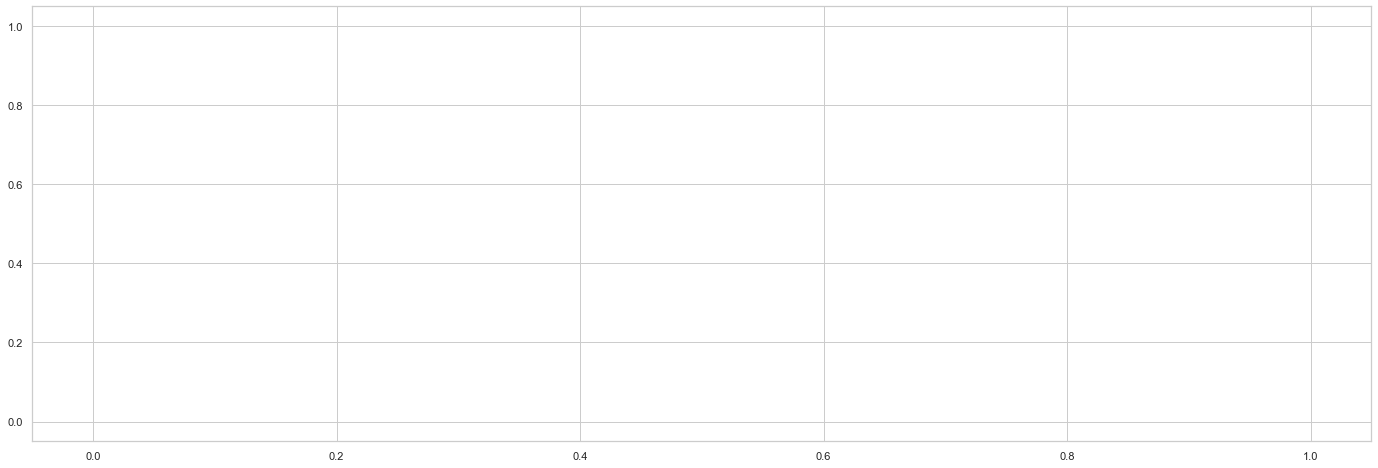

In [37]:
# Monthly PRs closed
pr_monthDF = pd.DataFrame()
print(pr_monthDF)
for value in repo_dict.repo_id: 
    print(value)
#    sql_DFa = pd.read_sql
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP {year_ago}, TIMESTAMP {today}, INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                                AND pull_requests.pr_src_state = 'closed'  
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value
#    pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]] = pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]].fillna(value=0)
    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    if not pr_monthDF.empty: 
#        print(sql_DFa)
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
#        print(sql_DF)
    else: 
        print('first time')
        pr_monthDF = pr_monthDFa
#        print(sql_DF)
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

import matplotlib.pyplot as plt
pr_monthDF['year'] = pr_monthDF['year'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF['repo_id'] = pr_monthDF['repo_id'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(lambda x: '{0:0>2}'.format(x))
pr_monthDF['yearmonth'] = pr_monthDF['year'].map(str)+pr_monthDF['month'].map(str)
#sql_DF['yearweek'] = sql_DF['yearweek'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF.set_index('repo_id', 'yearmonth')
#print(sql_DF)
#sql_DF.dtypes

sns.set_style('ticks')
#sns.palplot(sns.color_palette('husl', 8))
#sns.set_palette('husl')
sns.set(style="whitegrid")


#Total PRS open and closed by month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.lineplot(x='yearmonth', y='total_prs_open_closed', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Total Pull Requests Closed by Month in past year")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plottermonthlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=13)
fig.savefig('images/prs-monthly-total-open-closed.png')


#Average Days Open by Month
#fig, ax = plt.subplots()
# the size of A4 paper
#fig.set_size_inches(24, 24)
#plottermonth = sns.lineplot(x='yearmonth', y='wk_avg_days_to_close', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Closed PR Time Open by Month in past year")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
#plotterlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=8)
#fig.savefig('images/prs-average-open-time-month.png')
print(pr_monthDF)

In [38]:
print(pr_monthDF)

    month  year  repo_id repo_name repo_group total_prs_open_closed yearmonth
0       3  2019    26235      None       None                  None    201903
1       4  2019    26235      None       None                  None    201904
2       5  2019    26235      None       None                  None    201905
3       6  2019    26235      None       None                  None    201906
4       7  2019    26235      None       None                  None    201907
..    ...   ...      ...       ...        ...                   ...       ...
7      10  2019    27043     kpack    pivotal                    35    201910
8      11  2019    27043     kpack    pivotal                     9    201911
9      12  2019    27043     kpack    pivotal                    10    201912
10      1  2020    27043     kpack    pivotal                    22    202001
11      2  2020    27043     kpack    pivotal                    12    202002

[96 rows x 7 columns]


[Text(0, 0, '201903'),
 Text(0, 0, '201904'),
 Text(0, 0, '201905'),
 Text(0, 0, '201906'),
 Text(0, 0, '201907'),
 Text(0, 0, '201908'),
 Text(0, 0, '201909'),
 Text(0, 0, '201910'),
 Text(0, 0, '201911'),
 Text(0, 0, '201912'),
 Text(0, 0, '202001'),
 Text(0, 0, '202002')]

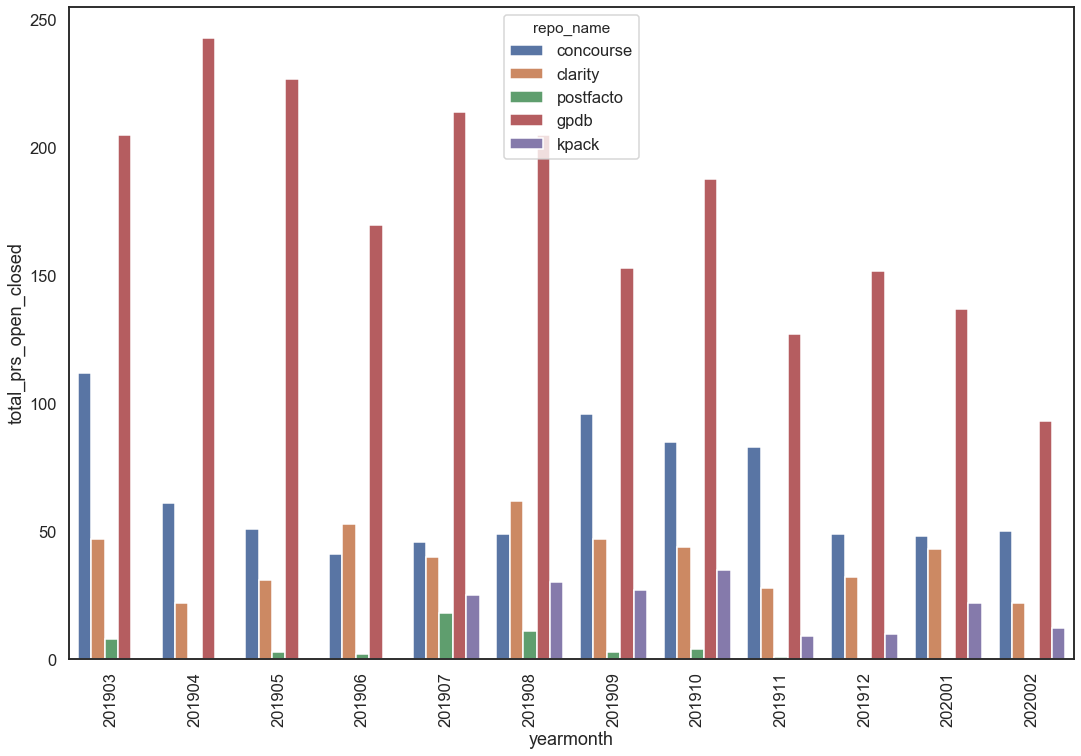

In [44]:
sns.set(style="white", context="talk")
plt.figure(figsize=(18,12))
plottermonth_bar = sns.barplot(x='yearmonth', y='total_prs_open_closed', hue='repo_name', data=pr_monthDF)
plottermonth_bar.set_xticklabels(plottermonth_bar.get_xticklabels(), rotation=90)

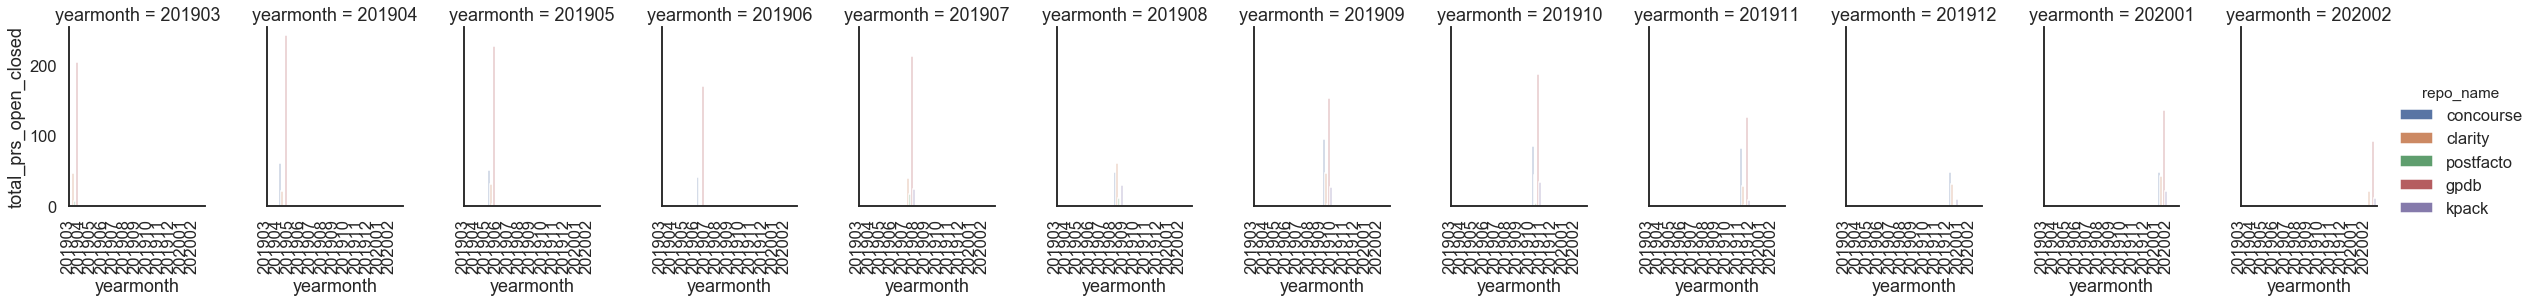

In [40]:
g = sns.catplot(x='yearmonth', y='total_prs_open_closed', hue='repo_name', data=pr_monthDF,
                col="yearmonth", kind="bar",
                height=4, aspect=.7);
g.set_xticklabels(rotation=90, horizontalalignment='right')
#g.set_xticklabels(g.get_xticklabels(), rotation=90)

Empty DataFrame
Columns: []
Index: []
26235
first time
28051
27913
26983
27169
25857
26600
27043


DataError: No numeric types to aggregate

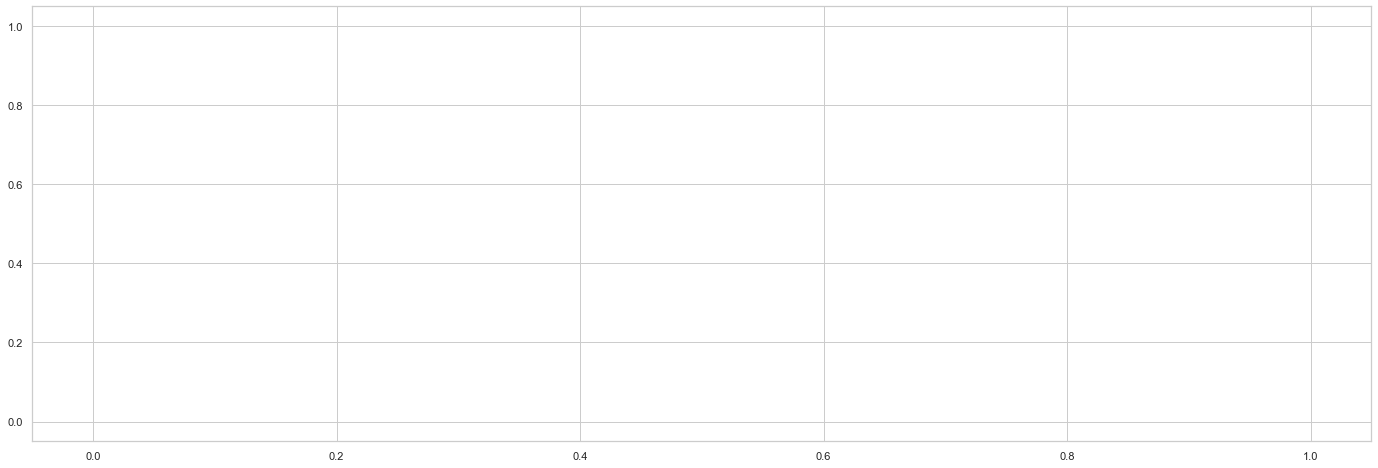

In [45]:
# Monthly PRs ALL - removed where pull_requests.pr_src_state = 'closed' 
pr_monthDF = pd.DataFrame()
print(pr_monthDF)
for value in repo_dict.repo_id: 
    print(value)
#    sql_DFa = pd.read_sql
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP {year_ago}, TIMESTAMP {today}, INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value
#    pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]] = pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]].fillna(value=0)
    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    if not pr_monthDF.empty: 
#        print(sql_DFa)
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
#        print(sql_DF)
    else: 
        print('first time')
        pr_monthDF = pr_monthDFa
#        print(sql_DF)
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

import matplotlib.pyplot as plt
pr_monthDF['year'] = pr_monthDF['year'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF['repo_id'] = pr_monthDF['repo_id'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(lambda x: '{0:0>2}'.format(x))
pr_monthDF['yearmonth'] = pr_monthDF['year'].map(str)+pr_monthDF['month'].map(str)
#sql_DF['yearweek'] = sql_DF['yearweek'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF.set_index('repo_id', 'yearmonth')
#print(sql_DF)
#sql_DF.dtypes

sns.set_style('ticks')
#sns.palplot(sns.color_palette('husl', 8))
#sns.set_palette('husl')
sns.set(style="whitegrid")


#Total PRS open and closed by month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.lineplot(x='yearmonth', y='total_prs_open_closed', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Total Pull Requests by Month in past year")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plottermonthlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=13)
fig.savefig('images/prs-monthly-total-open-closed.png')


#Average Days Open by Month
#fig, ax = plt.subplots()
# the size of A4 paper
#fig.set_size_inches(24, 24)
#plottermonth = sns.lineplot(x='yearmonth', y='wk_avg_days_to_close', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Closed PR Time Open by Month in past year")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
#plotterlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=8)
#fig.savefig('images/prs-average-open-time-month.png')
